# Overview
Currently experiencing a deficit of no mask images so this notebook will take images from the personal db and populate  the school db.

# Imports

In [31]:
import pickle
from PIL import Image 
from skimage import io
import random
import pandas as pd
import pymongo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import cross_val_score
from sklearn import tree
import numpy as np
import bson
import json
from IPython.display import clear_output
import time

# Connect to Race-Based DB

In [4]:
user = ""
pswd = ""

In [5]:
client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.ihx5p.mongodb.net/<dbname>?retryWrites=true&w=majority".format(user, pswd))
db_race = client["DATA_603"]
collection_race = db_race["test_images"]

# Connect to Active DB

In [7]:
user = ""
pswd = ""

In [8]:
client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.x6cn9.mongodb.net/DATA_603?retryWrites=true&w=majority".format(user, pswd))
db = client["DATA_603"]
collection = db["images_0"]

# Functions: Loading DataFrames

In [18]:
def load_test_df(collection=1):
    df_ = pd.DataFrame(db["test_{}".format(collection)].find({}))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: pickle.loads(x))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))
    
    return df_
    
def load_df():
    arr = []
    for i in range(1,56):
        try:
            temp = pd.DataFrame(db["images_{}".format(i)].find({}))
            temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: pickle.loads(x))
            temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))    
            arr.append(temp)
        except:
            # display(temp)
            continue

        if i % 5 == 0 and i < 50:
            print("{}%".format(2*i), end ="... ")
        if i == 50:
            print("Finished Loading")

    df = pd.concat(arr, ignore_index=True)
    return df    

def load_race_df():
    df = pd.DataFrame(collection_race.find({}))
    df["numpy_arr"] = df["numpy_arr"].apply(lambda x: pickle.loads(x))
    df["numpy_arr"] = df["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))
    
    return df

In [19]:
df_race = load_race_df()
df_race.shape

,_id,source_url,numpy_arr,race
0,African_American_0,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=356x280 a...,African American
1,African_American_1,https://image.shutterstock.com/image-photo/you...,<PIL.Image.Image image mode=RGB size=390x280 a...,African American
2,African_American_2,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=390x280 a...,African American
3,African_American_3,https://image.shutterstock.com/image-photo/mus...,<PIL.Image.Image image mode=RGB size=390x280 a...,African American
4,African_American_4,https://image.shutterstock.com/image-photo/fin...,<PIL.Image.Image image mode=RGB size=390x280 a...,African American
...,...,...,...,...
563,Native_Hawaiian_63,https://image.shutterstock.com/image-photo/por...,<PIL.Image.Image image mode=RGB size=183x280 a...,Native Hawaiian
564,Native_Hawaiian_64,https://image.shutterstock.com/image-photo/por...,<PIL.Image.Image image mode=RGB size=172x280 a...,Native Hawaiian
565,Native_Hawaiian_65,https://image.shutterstock.com/image-photo/haw...,<PIL.Image.Image image mode=RGB size=393x280 a...,Native Hawaiian
566,Native_Hawaiian_66,https://image.shutterstock.com/image-photo/por...,<PIL.Image.Image image mode=RGB size=173x280 a...,Native Hawaiian


In [121]:
# df_race["race"].value_counts().plot(kind="bar")

# Functions: Image reshaping

In [100]:
def my_crop(x):       
    w, h = x.size 
    h2 = int(h*.9)

    left = (1/2)*(w - h2)
    top = 0
    right = w - (1/2)*(w - h2)
    bottom = h2

    print(type(x))
    return x.crop((left, top, right, bottom))

def f(x):
    display(x)
    return x

# Functions: Main Loop Components

In [120]:
def save_location(r, m):
    location = {"race_index":r, "mask_index":m}
    with open('Merge_DB_Last_Saved.txt', 'w') as outfile:
        json.dump(location, outfile)

def open_saved_location():
    with open('Merge_DB_Last_Saved.txt') as json_file:
        location = json.load(json_file)
        return location
        
def add_to_mask_MongoDB(df, race_index, mask_index, collection, label):
    img = my_crop(df_race["numpy_arr"][race_index]).resize((150,150))
    
    temp = {"_id": "Extra_{}".format(mask_index),
            "source_url": df_race["source_url"][race_index],
            "numpy_arr": bson.binary.Binary( pickle.dumps( np.array(img), protocol=2) ),
            "target": label,
            "hand_labled_target": label}

    try:
        collection.insert_one(temp)
    except:
        collection.find_one_and_replace({"_id": temp["_id"]}, temp)

def reset():
    save_location(r=0, m=0)
    
def view_all_new_images():
    df = pd.DataFrame(collection.find({}))

    df["numpy_arr"] = df["numpy_arr"].apply(lambda x: pickle.loads(x))
    df["numpy_arr"] = df["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))
    
    for index, row in df.iterrows():
        print(index)
        display(row["numpy_arr"])

# Main Cell: Loop through each race to add photos to the mask database 
collection = images_0

Index 55 out of 567


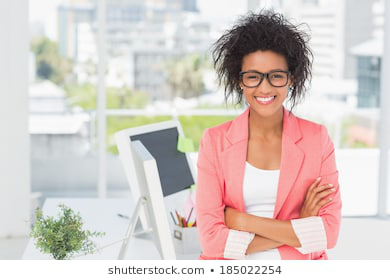

Please enter one of the following:
	 'y' If you want to add the image.
	 'n' If you don't want to add the image.
	  Or press  Enter to end the session.

{'race_index': 55, 'mask_index': 135}


In [119]:
location = open_saved_location()
mask_index = location["mask_index"]

for race_index in range(location["race_index"], len(df_race)):
    save_location(race_index, mask_index)
    user = "---"

    while user.lower() not in ["y", "n", ""]:
        clear_output()
        print("Index {} out of {}".format(race_index, len(df_race)-1))
        display(df_race["numpy_arr"][race_index])

        prompt = "Please enter one of the following:"
        prompt += "\n\t 'y' If you want to add the image."
        prompt += "\n\t 'n' If you don't want to add the image."
        prompt += "\n\t  Or press  Enter to end the session.\n"

        user = input(prompt)
    if user.lower() == "y":
        add_to_mask_MongoDB(df_race, race_index, mask_index, collection, "No Mask")
        mask_index += 1
    elif user.lower() == "n":
        pass    
    else:
        break

    clear_output()
    print("You entered:\t", user)
    #time.sleep(.5)
    clear_output()
        
save_location(race_index, mask_index)
print(open_saved_location())

In [73]:
print(open_saved_location())

{'race_index': 548, 'mask_index': 135}


In [116]:
save_location(55, 135)